In [1]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

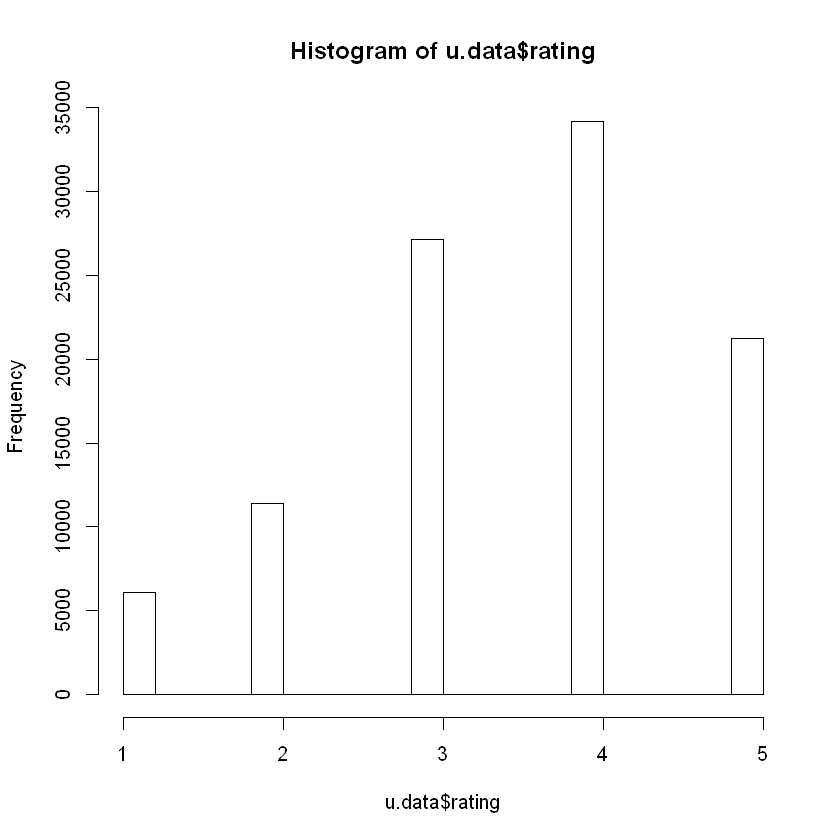

In [2]:
hist.values <- hist(u.data$rating)

$breaks
 [1] 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6 3.8 4.0 4.2 4.4 4.6
[20] 4.8 5.0

$counts
 [1]  6110     0     0     0 11370     0     0     0     0 27145     0     0
[13]     0     0 34174     0     0     0     0 21201

$density
 [1] 0.30550 0.00000 0.00000 0.00000 0.56850 0.00000 0.00000 0.00000 0.00000
[10] 1.35725 0.00000 0.00000 0.00000 0.00000 1.70870 0.00000 0.00000 0.00000
[19] 0.00000 1.06005

$mids
 [1] 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5 4.7
[20] 4.9

$xname
[1] "u.data$rating"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

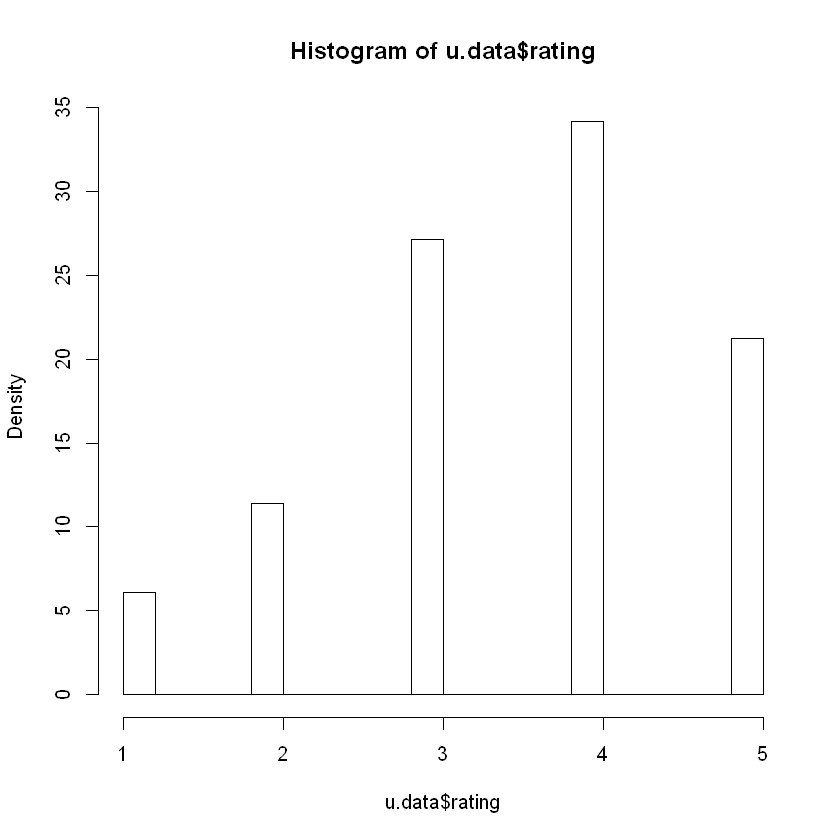

In [3]:
hist.values
hist.values$density = hist.values$counts/sum(hist.values$counts)*100
plot(hist.values,freq=FALSE)

In [4]:
hist.prob <- round(100*hist.values$counts/sum(hist.values$counts))

In [5]:
hist.prob

[1]  6  0  0  0 11  0  0  0  0 27  0  0  0  0 34  0  0  0  0 21

In [6]:
rand.dist <- rep(1,6*16000)

In [7]:
sum(m==0)

[1] 1486126

In [8]:
rand.dist <- c(rand.dist, rep(2,11*16000))
rand.dist <- c(rand.dist, rep(3,27*16000))
rand.dist <- c(rand.dist, rep(4,34*16000))
rand.dist <- c(rand.dist, rep(5,21*16000))

In [9]:
sample(rand.dist,1)

[1] 2

In [1]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b]*5, m.na[i.test.b])
    }
to.plot <- c()

In [1]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
length(i.hasard)
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train[m.train==0] <-sample(rand.dist,sum(m.train==0))
m.train <- m.train/5
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }


ERROR: Error in which(m > 0): object 'm' not found


In [26]:
to.plot<-as.matrix(to.plot)

In [35]:
to.plot<-apply(to.plot,2,unlist)

In [47]:
sdev <- apply(to.plot,2,sd) 
sdev
avg <- colMeans(to.plot)
x <- 1:length(avg)

[1] 0.004724022 0.006061009 0.006345743 0.006637425 0.006311462 0.006370608
 [7] 0.006329227 0.006169037 0.006045736 0.006142747 0.005988263 0.006097685
[13] 0.005803862 0.005739250 0.005605832 0.005816452 0.005811709 0.005774201
[19] 0.005833453 0.005913557 0.005858122

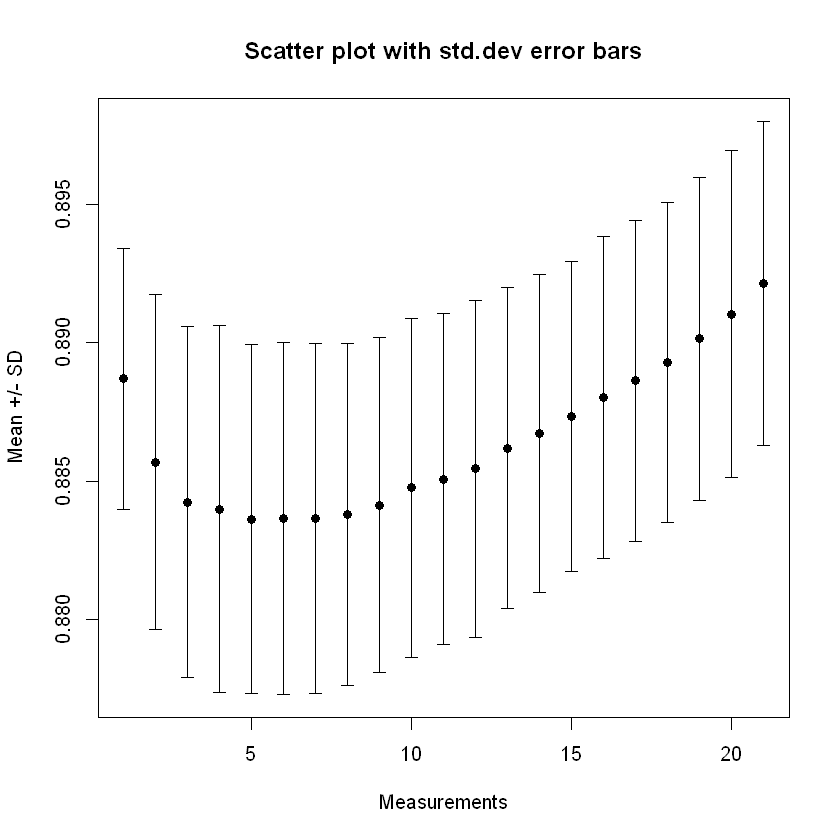

In [48]:
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [ ]:
plot(x, avg,
    ylim=range(c(avg-sdev, avg+sdev)),
    pch=19, xlab="Measurements", ylab="Mean +/- SD",
    main="Scatter plot with std.dev error bars"
)

In [ ]:
new.m <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2*5, m.na)
    }
to.plot.1 <- lapply(seq(1,943,30), new.m)

In [ ]:
hist.values2 <- hist(m)
hist.values2$density = hist.values2$counts/sum(hist.values2$counts)*100


In [ ]:
plot(hist.values,freq=FALSE)
plot(hist.values2,freq=FALSE)

In [ ]:
CSV.write('random.csv', csv, append = FALSE, first.cell = "RowName")

In [4]:
m[1,]

i1    i2    i3    i4    i5    i6    i7    i8    i9   i10   i11   i12   i13 
    5     3     4     3     3     5     4     1     5     3     2     5     5 
  i14   i15   i16   i17   i18   i19   i20   i21   i22   i23   i24   i25   i26 
    5     5     5     3     4     5     4     1     4     4     3     4     3 
  i27   i28   i29   i30   i31   i32   i33   i34   i35   i36   i37   i38   i39 
    2     4     1     3     3     5     4     2     1     2     2     3     4 
  i40   i41   i42   i43   i44   i45   i46   i47   i48   i49   i50   i51   i52 
    3     2     5     4     5     5     4     4     5     3     5     4     4 
  i53   i54   i55   i56   i57   i58   i59   i60   i61   i62   i63   i64   i65 
    3     3     5     4     5     4     5     5     4     3     2     5     4 
  i66   i67   i68   i69   i70   i71   i72   i73   i74   i75   i76   i77   i78 
    4     3     4     3     3     3     4     3     1     4     4     4     1 
  i79   i80   i81   i82   i83   i84   i85   i86   i87   i88   i89   i90   i91 
    4     4     5     5     3     4     3     5     5     4     5     4     5 
  i92   i93   i94   i95   i96   i97   i98   i99  i100  i101  i102  i103  i104 
    3     5     2     4     5     3     4     3     5     2     2     1     1 
 i105  i106  i107  i108  i109  i110  i111  i112  i113  i114  i115  i116  i117 
    2     4     4     5     5     1     5     1     5     5     5     3     3 
 i118  i119  i120  i121  i122  i123  i124  i125  i126  i127  i128  i129  i130 
    3     5     1     4     3     4     5     3     2     5     4     5     3 
 i131  i132  i133  i134  i135  i136  i137  i138  i139  i140  i141  i142  i143 
    1     4     4     4     4     3     5     1     3     1     3     2     1 
 i144  i145  i146  i147  i148  i149  i150  i151  i152  i153  i154  i155  i156 
    4     2     4     3     2     2     5     4     5     3     5     2     4 
 i157  i158  i159  i160  i161  i162  i163  i164  i165  i166  i167  i168  i169 
    4     3     3     4     4     4     4     3     5     5     2     5     5 
 i170  i171  i172  i173  i174  i175  i176  i177  i178  i179  i180  i181  i182 
    5     5     5     5     5     5     5     5     5     3     3     5     4 
 i183  i184  i185  i186  i187  i188  i189  i190  i191  i192  i193  i194  i195 
    5     4     4     4     4     3     3     5     5     4     4     4     5 
 i196  i197  i198  i199  i200  i201  i202  i203  i204  i205  i206  i207  i208 
    5     5     5     4     3     3     5     4     5     3     4     5     5 
 i209  i210  i211  i212  i213  i214  i215  i216  i217  i218  i219  i220  i221 
    4     4     3     4     2     4     3     5     3     3     1     3     5 
 i222  i223  i224  i225  i226  i227  i228  i229  i230  i231  i232  i233  i234 
    4     5     5     2     3     4     5     4     4     1     3     2     4 
 i235  i236  i237  i238  i239  i240  i241  i242  i243  i244  i245  i246  i247 
    5     4     2     4     4     3     4     5     1     2     2     5     1 
 i248  i249  i250  i251  i252  i253  i254  i255  i256  i257  i258  i259  i260 
    4     4     4     4     2     5     1     2     4     4     5     1     1 
 i261  i262  i263  i264  i265  i266  i267  i268  i269  i270  i271  i272  i273 
    1     3     1     2     4     1     4     5     5     5     2     3     0 
 i274  i275  i276  i277  i278  i279  i280  i281  i282  i283  i284  i285  i286 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 i287  i288  i289  i290  i291  i292  i293  i294  i295  i296  i297  i298  i299 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 i300  i301  i302  i303  i304  i305  i306  i307  i308  i309  i310  i311  i312 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 i313  i314  i315  i316  i317  i318  i319  i320  i321  i322  i323  i324  i325 
    0     0     0     0     0     0     0     0     0     0     0     0     0 
 i326  i327  i328  i329  i330  i331  i332  i333  i334